Increasing Llama2 4K context window to Code llama 16K context window(that can extrapolate up to 100k tokens) this was possible due to recent development in RoPE scaling, the model shows state of the art performance in python, C++, Java, PHP, C#, TypeScript and Bash


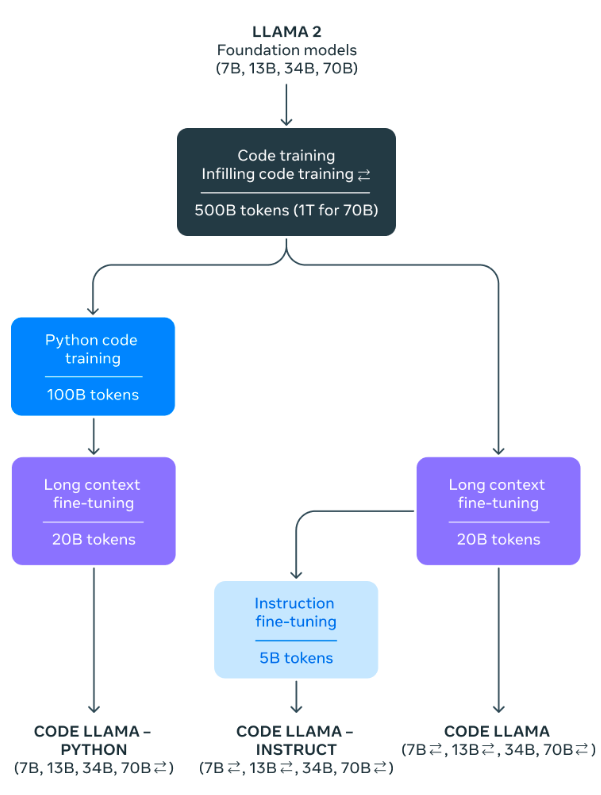

In [ ]:
!pip install accelerate peft bitsandbytes transformers trl

In [3]:
from huggingface_hub import notebook_login
notebook_login()

**MODEL TRAINING**

In [3]:
import torch
from datasets import load_dataset, Dataset
from peft import LoraConfig, AutoPeftModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments
from trl import SFTTrainer
import os

def finetune_llama_v2():
    data = load_dataset("code_x_glue_tc_nl_code_search_adv", split="validation") # taking only validation data
    data_df = data.to_pandas() # converting it into pandas dataframe
    data_df["text"] = data_df[["docstring", "code"]].apply(lambda x: "[INST] Docstring: " + x["docstring"] + " [/INST] Code: " + x["code"] + "", axis=1)
    data = Dataset.from_pandas(data_df) # converting pandas dataframe into datasets.dataset_dict.DatasetDict
    tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-hf") # model tokenization
    tokenizer.pad_token = tokenizer.eos_token
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype="float16", bnb_4bit_use_double_quant=True
    ) # Quantization
    model = AutoModelForCausalLM.from_pretrained(
        "codellama/CodeLlama-7b-hf", quantization_config=bnb_config, device_map="auto"
    ) # model tokenization
    model.config.use_cache=False # FALSE means we are finetuning it, not inferencing it
    model.config.pretraining_tp=1
    peft_config = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
    ) # Parameter-Efficient Fine-Tuning (PEFT)
    training_arguments = TrainingArguments(
        output_dir="codellama2-finetuned-codex",
        per_device_train_batch_size=2,
        gradient_accumulation_steps=8,
        optim="paged_adamw_32bit",
        learning_rate=2e-4,
        lr_scheduler_type="cosine",
        save_strategy="epoch",
        logging_steps=10,
        num_train_epochs=1,
        max_steps=100,
        fp16=True,
        push_to_hub=True
    )
    trainer = SFTTrainer(
        model=model,
        train_dataset=data,
        peft_config=peft_config,
        dataset_text_field="text",
        args=training_arguments,
        tokenizer=tokenizer,
        packing=False,
        max_seq_length=256
    )
    trainer.train()
    trainer.push_to_hub()

if __name__ == "__main__":
    finetune_llama_v2()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/251820 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9604 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/19210 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

Map:   0%|          | 0/9604 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:294: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
10,1.418400
20,1.302700
30,1.162500
40,1.047900
50,1.093200
60,1.060900
70,1.011200
80,1.013800
90,0.980500
100,1.017300


**Model Saving**

In [4]:
! cp -r /content/codellama2-finetuned-codex /content/drive/MyDrive/

In [3]:
from peft import AutoPeftModelForCausalLM, PeftModel
from transformers import AutoModelForCausalLM
import torch
import os
model = AutoModelForCausalLM.from_pretrained(
            "codellama/CodeLlama-7b-hf", torch_dtype=torch.float16, load_in_8bit=False, device_map="auto", trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/637 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [4]:
peft_model = PeftModel.from_pretrained(model, "SNV/codellama2-finetuned-codex", from_transformers=True, device_map={"":0})

adapter_config.json:   0%|          | 0.00/600 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/16.8M [00:00<?, ?B/s]

In [6]:
model = peft_model.merge_and_unload() # merging the code llama with our trained code llama

In [7]:
model.push_to_hub("codellama2-finetuned-codex-fin")

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/SNV/codellama2-finetuned-codex-fin/commit/5fbec120f58529752aece12c0c0589269fd72709', commit_message='Upload LlamaForCausalLM', commit_description='', oid='5fbec120f58529752aece12c0c0589269fd72709', pr_url=None, pr_revision=None, pr_num=None)

In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("codellama/CodeLlama-7b-hf") # taking the tokenizerfrom code llama and pushing to hub
tokenizer.push_to_hub("codellama2-finetuned-codex-fin")

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/SNV/codellama2-finetuned-codex-fin/commit/911650cbe9219457e61fc8b784e5488f1761a2df', commit_message='Upload tokenizer', commit_description='', oid='911650cbe9219457e61fc8b784e5488f1761a2df', pr_url=None, pr_revision=None, pr_num=None)

**Model Inference**

In [2]:
from transformers import AutoTokenizer
from transformers import pipeline
import torch

tokenizer = AutoTokenizer.from_pretrained("SNV/codellama2-finetuned-codex-fin")
pipe = pipeline(
    "text-generation",
    model="SNV/codellama2-finetuned-codex-fin",
    torch_dtype=torch.float16,
    device_map="auto",
)

sequences = pipe(
    'def fibonacci(',
    do_sample=True,
    temperature=0.2,
    top_p=0.9,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    max_length=100,
)
for seq in sequences:
    print(f"Result: {seq['generated_text']}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.59G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


RuntimeError: "addmm_impl_cpu_" not implemented for 'Half'